In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [62]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.mu = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        self.rho = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu)
            
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma)
        
        rho = torch.log(torch.exp(sigma) - 1)
        
        nn.init.constant_(self.mu, mu)
        nn.init.constant_(self.rho, rho)
        
    def set_mu(self, mu):
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu).float()
        nn.init.constant_(self.mu, mu)
        
        
    def set_rho(self, rho):
        if not torch.is_tensor(rho):
            rho = torch.tensor(rho).float()
        nn.init.constant_(self.rho, rho)
       
    def set_sigma(self, sigma):
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma).float()
        rho = self._sigma_to_rho(sigma)
        self.set_rho(rho)
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def sample(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return epsilon.mul(sigma).add(self.mu)
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    def _sigma_to_rho(self, sigma):
        rho = torch.log(torch.exp(sigma) - 1)
        return rho
    
    def log_prob(self, z):
        S = torch.diag(self.sigma)
        return torch.distributions.multivariate_normal.MultivariateNormal(self.mu, scale_tril=S).log_prob(z).unsqueeze(-1)

# Variational Distribution #

In [63]:
q = MeanFieldVariationalDistribution(1)

<IPython.core.display.Javascript object>


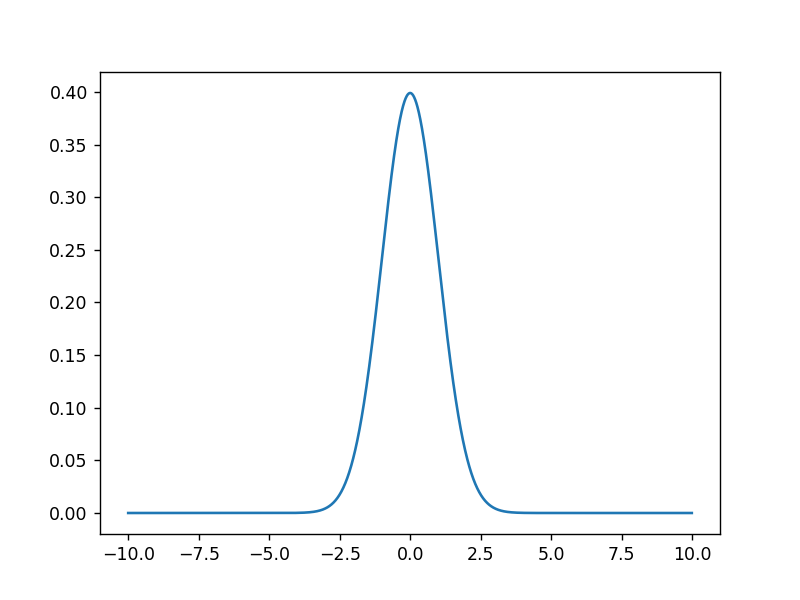

In [64]:
%matplotlib notebook
x = np.arange(-10, 10.0, 0.01)
plt.plot(x, stats.norm.pdf(x, q.mu.detach().numpy(), q.sigma.detach().numpy()))
plt.show()

# Prior #

In [65]:
prior_mu = 0.0
prior_sigma = 1.0

In [66]:
def prior(x):
    return stats.norm.pdf(x, prior_mu, prior_sigma)

def logprior(x):
    return torch.distributions.normal.Normal(prior_mu, prior_sigma).log_prob(x)

# Likelihood #

In [67]:
likelihood_mu = -8.0
likelihood_sigma = 1.0

In [68]:
def likelihood(x):
    return stats.norm.pdf(x, likelihood_mu, likelihood_sigma)

def loglikelihood(x):
    return torch.distributions.normal.Normal(likelihood_mu, likelihood_sigma).log_prob(x)

# Posterior #

In [69]:
def conjugate_gaussian(mu1, sigma1, mu2, sigma2):
    mu = (mu1*sigma2**2 + mu2*sigma1**2) / (sigma1**2 + sigma2**2)
    sigma = np.sqrt((sigma2**2 * sigma1**2) / (sigma1**2 + sigma2**2))
    return mu, sigma

In [70]:
def posterior(x):
    mu, sigma = conjugate_gaussian(prior_mu, prior_sigma, likelihood_mu, likelihood_sigma)
    return stats.norm.pdf(x, mu, sigma)

In [71]:
def logposterior(x):
    mu, sigma = conjugate_gaussian(prior_mu, prior_sigma, likelihood_mu, likelihood_sigma)
    return torch.distributions.normal.Normal(mu, sigma).log_prob(x)

<IPython.core.display.Javascript object>


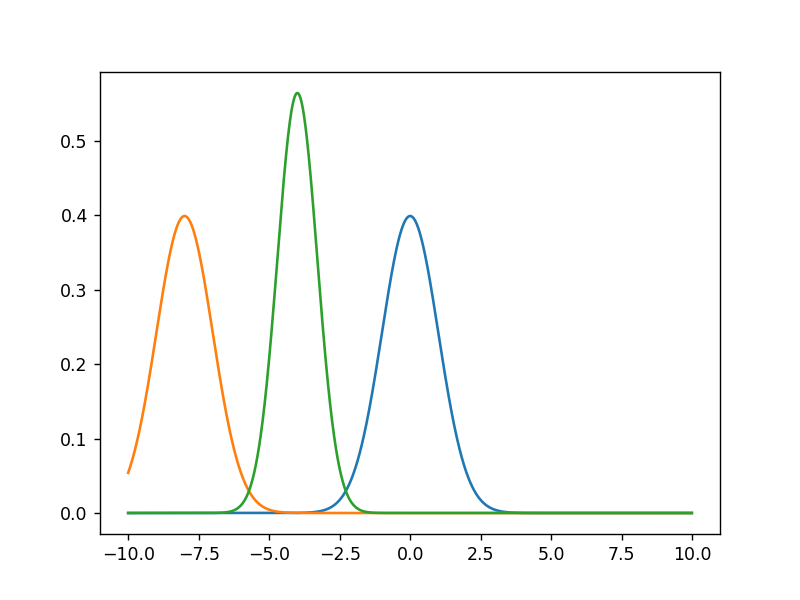

In [72]:
%matplotlib notebook
%matplotlib notebook

x = np.arange(-10, 10.0, 0.01)
plt.plot(x, prior(x))
plt.plot(x, likelihood(x))
plt.plot(x, posterior(x))
plt.show()

In [73]:
q = MeanFieldVariationalDistribution(1)

In [74]:
n_samples_ELBO = 1

In [75]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

In [76]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logprior(z)
    LL = loglikelihood(z)
    L = (LQ - LP - LL).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        if n_samples_ELBO > 1000:
            break
        else:
            optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)
            n_samples_ELBO = n_samples_ELBO*10
        

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


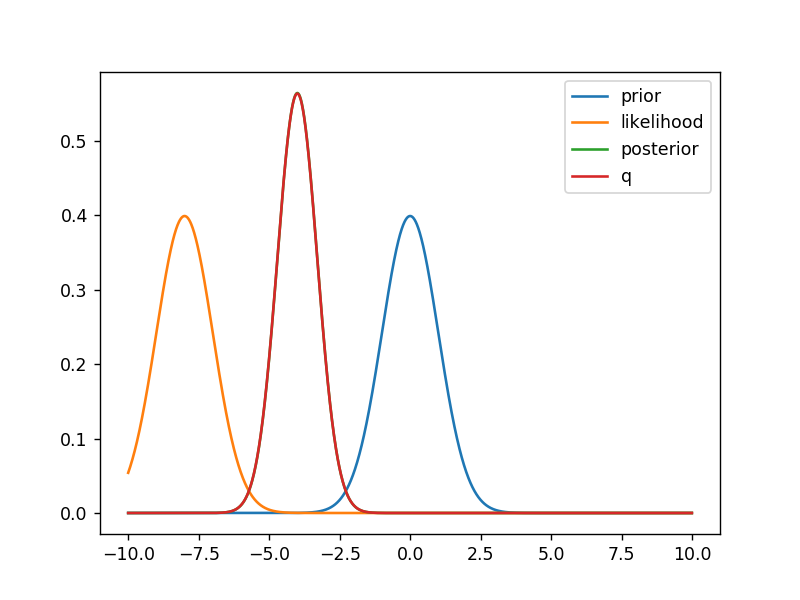

In [77]:
%matplotlib notebook
%matplotlib notebook

x = np.arange(-10, 10.0, 0.01)
plt.plot(x, prior(x))
plt.plot(x, likelihood(x))
plt.plot(x, posterior(x))
plt.plot(x, stats.norm.pdf(x, q.mu.detach().numpy(), q.sigma.detach().numpy()))
plt.legend(['prior', 'likelihood', 'posterior', 'q'])
plt.show()

In [170]:
n_samples_ELBO = 10
z = q.sample(n_samples_ELBO)
LQ = q.log_prob(z)
LP = logprior(z)
LL = loglikelihood(z)
L = (LQ - LP - LL).sum()/n_samples_ELBO
L

tensor(6909.7329, grad_fn=<DivBackward0>)